In [1]:
import torch
import torch.nn as nn
import pandas as pd
from project.dataset import Dataset, VALDODataset
from torch.utils.data import DataLoader
from project.preprocessing import NiftiToTensorTransform
from project.utils import collatev2
import winsound
from project.utils import compute_statistics
from project.evaluation import isa_rpn_metric, isa_vit_metric, Tracker

In [2]:
vit_tk = Tracker()
rpn_tk = Tracker()

### Monitoring and CUDA Setup


In [3]:
import logging
from datetime import datetime as dtt
import os

path = 'logs'
os.makedirs(path, exist_ok=True)
os.makedirs('history', exist_ok=True)
rn = dtt.now()
dte = rn.strftime('%b_%d_%Y_%H%M%S')

logger = logging.getLogger('kess')
fh = logging.FileHandler(f'logs/rpn_vit_{dte}.log')
formatter = logging.Formatter(
    '%(asctime)s - %(levelname)s - %(message)s'
)

logger.setLevel(logging.DEBUG)
fh.setLevel(logging.DEBUG)
fh.setFormatter(formatter)

logger.addHandler(fh)

dte

'Nov_20_2024_234602'

In [4]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [5]:
vit_tk.date = rn
vit_tk.logfile = f'rpn_vit_{dte}.log'
vit_tk.device = device

### Config for RPN and ViT Fitter


In [6]:
from project.model import RPN, ISAVIT

rpn_config = {
    'model': RPN(
        input_dim=512,
        output_dim=4,
        image_size=300,
        global_context=True,
        nh=4,
        pretrained=True
    ).to(device),
}

c:\Users\Lex Zedrick Lorenzo\AppData\Local\Programs\Python\Python312\Lib\site-packages\torch\nn\modules\transformer.py:306: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


In [7]:
vit_config = {
    'model': ISAVIT(
        d_model=512,
        patch_size=32,
        dim_ff=1600,
        global_context=True,
    ).to(device),
    'optimizer': torch.optim.Adam,
    'device': device,
    'epochs': 10,
    'loss': nn.BCEWithLogitsLoss(),
    'lr': 0.0001
}

In [8]:
vit_tk.model = 'ViT'
vit_tk.model_hyperparams = vit_config['model'].config
vit_tk.optimizer = f"{vit_config['optimizer']}"
vit_tk.epochs = vit_config['epochs']
vit_tk.loss = f"{vit_config['loss']}"
vit_tk.lr = vit_config['lr']

rpn_tk.model = 'RPN'
rpn_tk.model_hyperparams = rpn_config['model'].config

### Dataset Loading


In [9]:
data = pd.read_csv('targets.csv')
data.shape

(7986, 9)

In [10]:
data = data.query('has_microbleed_slice == 1').reset_index(drop=True)
vit_tk.only_cmb_slices = True
data

,mri,masks,stripped,target,has_microbleed_case,has_microbleed_slice,cohort,max_value,slices
0,c:\Users\Lex Zedrick Lorenzo\Documents\GitHub\...,c:\Users\Lex Zedrick Lorenzo\Documents\GitHub\...,c:\Users\Lex Zedrick Lorenzo\Documents\GitHub\...,8,1,1,1,928.405273,35
1,c:\Users\Lex Zedrick Lorenzo\Documents\GitHub\...,c:\Users\Lex Zedrick Lorenzo\Documents\GitHub\...,c:\Users\Lex Zedrick Lorenzo\Documents\GitHub\...,9,1,1,1,928.405273,35
2,c:\Users\Lex Zedrick Lorenzo\Documents\GitHub\...,c:\Users\Lex Zedrick Lorenzo\Documents\GitHub\...,c:\Users\Lex Zedrick Lorenzo\Documents\GitHub\...,11,1,1,1,928.405273,35
3,c:\Users\Lex Zedrick Lorenzo\Documents\GitHub\...,c:\Users\Lex Zedrick Lorenzo\Documents\GitHub\...,c:\Users\Lex Zedrick Lorenzo\Documents\GitHub\...,12,1,1,1,928.405273,35
4,c:\Users\Lex Zedrick Lorenzo\Documents\GitHub\...,c:\Users\Lex Zedrick Lorenzo\Documents\GitHub\...,c:\Users\Lex Zedrick Lorenzo\Documents\GitHub\...,15,1,1,1,928.405273,35
...,...,...,...,...,...,...,...,...,...
359,c:\Users\Lex Zedrick Lorenzo\Documents\GitHub\...,c:\Users\Lex Zedrick Lorenzo\Documents\GitHub\...,c:\Users\Lex Zedrick Lorenzo\Documents\GitHub\...,25,1,1,3,241.000000,36
360,c:\Users\Lex Zedrick Lorenzo\Documents\GitHub\...,c:\Users\Lex Zedrick Lorenzo\Documents\GitHub\...,c:\Users\Lex Zedrick Lorenzo\Documents\GitHub\...,26,1,1,3,241.000000,36
361,c:\Users\Lex Zedrick Lorenzo\Documents\GitHub\...,c:\Users\Lex Zedrick Lorenzo\Documents\GitHub\...,c:\Users\Lex Zedrick Lorenzo\Documents\GitHub\...,24,1,1,3,448.000000,39
362,c:\Users\Lex Zedrick Lorenzo\Documents\GitHub\...,c:\Users\Lex Zedrick Lorenzo\Documents\GitHub\...,c:\Users\Lex Zedrick Lorenzo\Documents\GitHub\...,25,1,1,3,448.000000,39


### Preprocessing and Train-Test Split Function


In [11]:
from sklearn.model_selection import train_test_split

def make_loaders(data,
                 cohort,
                 test_size=0.2,
                 random_state=12,
                 target_shape=(300, 300),
                 rpn_mode=True,
                 logger=None,
                 vit_tracker=vit_tk
                ):
    if cohort == 1:
        vit_tracker.cohort1 = True
    if cohort == 2:
        vit_tracker.cohort2 = True
    if cohort == 3:
        vit_tracker.cohort3 = True
    
    vit_tracker.target_shape = target_shape
    data = data[data.cohort == cohort]
    
    s = f'Creating loaders for Cohort {cohort}\n'

    data_train, data_test = train_test_split(
        data,
        test_size=test_size,
        random_state=random_state
    )

    s += f'TRAIN & TEST: {data_train.shape, data_test.shape}\n'

    paths = data_train.stripped.unique().tolist()
    s += f'Total Unique MRI Samples in data_train: {len(paths)}\n'
    
    global_min, global_max = compute_statistics(paths)
    s += f'GLOBAL MIN & MAX {global_min, global_max}\n'

    transform = NiftiToTensorTransform(
        target_shape=target_shape,
        rpn_mode=rpn_mode,
        normalization=(global_min, global_max)
    )

    train_set = VALDODataset(
        cases=data_train.stripped.tolist(),
        masks=data_train.masks.tolist(),
        target=data_train.target.tolist(),
        transform=transform
    )
    val_set = VALDODataset(
        cases=data_test.stripped.tolist(),
        masks=data_test.masks.tolist(),
        target=data_test.target.tolist(),
        transform=transform
    )

    if logger != None:
        logger.info(s)
    else:
        print(s)
    
    return train_set, val_set

### ViT Fitter


In [12]:
from project import Fitter

class ViTFitter(Fitter):
    
    def fit(self, train_loader, val_loader, stage1):
        train_history = []
        val_history = []
        train_metric_history = []
        val_metric_history = []
        for epoch in range(self.epochs):
            self.log(f'EPOCH {epoch} ==============================')
            train_loss, train_metric = self.train_one_epoch(train_loader, stage1)
            val_loss, val_metric = self.validation(val_loader, stage1)
            train_history.append(train_loss)
            val_history.append(val_loss)
            train_metric_history.append(train_metric)
            val_metric_history.append(val_metric)
        return train_history, val_history, train_metric_history, val_metric_history

    def train_one_epoch(self, train_loader, stage1):
        self.model.train()
        loss_history = []
        evaluation_metric = {
            'dice_score': [], 
            'precision_score': [], 
            'recall_score': [], 
            'f1_score': [],
            'fpr': []
        }
        counter = 0
        for batch in train_loader:
            Y = []
            T = []
            for slices, masks, target, case in batch:
                # slices = slices.squeeze(1).float().to(self.device)
                slices = slices.squeeze(1).repeat(1, 3, 1, 1).float().to(self.device)
                masks = masks.float().to(self.device)

                with torch.inference_mode():
                    x, t = stage1(slices, masks, target)
                
                # self.log(f'{x.requires_grad}, {t.requires_grad}')
                # self.log(f'{x.shape}, {t.shape}')

                x = x.flatten(2).float().to(self.device)
                t = t.flatten(2).float().to(self.device)
                # self.log(f'XT SHAPES: {x.shape}, {t.shape}')
                
                y = self.model(x, target)
                
                # print('Prediction:', (y.sigmoid() >= 0.5).int().unique())
                # print('Truth:', (t[target] >= 0).int().unique())

                dice_score, precision_score, recall_score, f1_score, fpr = isa_vit_metric((y.sigmoid().squeeze().detach().cpu().numpy() >= 0.5), (t[target].squeeze().detach().cpu().numpy() > 0))

                evaluation_metric['dice_score'].append(dice_score)
                evaluation_metric['precision_score'].append(precision_score)
                evaluation_metric['recall_score'].append(recall_score)
                evaluation_metric['f1_score'].append(f1_score)
                evaluation_metric['fpr'].append(fpr)
                # self.log(f'EVAL METS: {dice_score, precision_score, recall_score, f1_score, fpr}')

                Y.append(y)
                T.append(t[target])
            
            losses = self.loss(torch.stack(Y), torch.stack(T))
            self.optimizer.zero_grad()
            losses.backward()
            self.optimizer.step()
            counter += 1
            self.log(f'Batch:\t{counter}/{len(train_loader)}')
            self.log(f'Batch samples:\t{len(batch)}')
            self.log(f'Current error:\t{losses}\n')
            
            loss_history.append(losses.detach().cpu().numpy())
        
        self.log(f'\nTraining Evaluation Metric:')
        self.log(f"Avg Dice: {sum(evaluation_metric['dice_score']) / len(evaluation_metric['dice_score'])}")
        self.log(f"Avg Precision: {sum(evaluation_metric['precision_score']) / len(evaluation_metric['precision_score'])}")
        self.log(f"Avg Recall: {sum(evaluation_metric['recall_score']) / len(evaluation_metric['recall_score'])}")
        self.log(f"Avg F1: {sum(evaluation_metric['f1_score']) / len(evaluation_metric['f1_score'])}")
        self.log(f"Avg FPR: {sum(evaluation_metric['fpr']) / len(evaluation_metric['fpr'])}\n")
        return loss_history, evaluation_metric
    
    def validation(self, val_loader, stage1):
        self.model.eval()
        loss_history = []
        evaluation_metric = {
            'dice_score': [], 
            'precision_score': [], 
            'recall_score': [], 
            'f1_score': [],
            'fpr': []
        }
        with torch.inference_mode():
            for batch in val_loader:
                Y = []
                T = []
                for slices, masks, target, case in batch:
                    # slices = slices.squeeze(1).float().to(self.device)
                    slices = slices.squeeze(1).repeat(1, 3, 1, 1).float().to(self.device)
                    masks = masks.float().to(self.device)
                    x, t = stage1(slices, masks, target)
                    x = x.flatten(2).float().to(self.device)
                    t = t.flatten(2).float().to(self.device)
                    y = self.model(x, target)

                    dice_score, precision_score, recall_score, f1_score, fpr = isa_vit_metric((y.sigmoid().squeeze().detach().cpu().numpy() >= 0.5), (t[target].squeeze().detach().cpu().numpy() > 0))
                    evaluation_metric['dice_score'].append(dice_score)
                    evaluation_metric['precision_score'].append(precision_score)
                    evaluation_metric['recall_score'].append(recall_score)
                    evaluation_metric['f1_score'].append(f1_score)
                    evaluation_metric['fpr'].append(fpr)
                    Y.append(y)
                    T.append(t[target])
                
                losses = self.loss(torch.stack(Y), torch.stack(T))
                loss_history.append(losses.cpu().numpy())
        
        self.log(f'\nValidations Evaluation Metric:')
        self.log(f"Avg Dice: {sum(evaluation_metric['dice_score']) / len(evaluation_metric['dice_score'])}")
        self.log(f"Avg Precision: {sum(evaluation_metric['precision_score']) / len(evaluation_metric['precision_score'])}")
        self.log(f"Avg Recall: {sum(evaluation_metric['recall_score']) / len(evaluation_metric['recall_score'])}")
        self.log(f"Avg F1: {sum(evaluation_metric['f1_score']) / len(evaluation_metric['f1_score'])}")
        self.log(f"Avg FPR: {sum(evaluation_metric['fpr']) / len(evaluation_metric['fpr'])}\n")
        return loss_history, evaluation_metric

### Train-Test Split


In [13]:
vit_t1, vit_v1 = make_loaders(
    data=data,
    cohort=1,
    rpn_mode=False
)

vit_t3, vit_v3 = make_loaders(
    data=data,
    cohort=3,
    rpn_mode=False
)

Creating loaders for Cohort 1
TRAIN & TEST: ((36, 9), (9, 9))
Total Unique MRI Samples in data_train: 8
GLOBAL MIN & MAX (0.0, 1417.92822265625)

Creating loaders for Cohort 3
TRAIN & TEST: ((37, 9), (10, 9))
Total Unique MRI Samples in data_train: 26
GLOBAL MIN & MAX (0.0, 573.0)



In [14]:
from torch.utils.data import ConcatDataset

vit_train_set = ConcatDataset([vit_t1, vit_t3])
vit_test_set = ConcatDataset([vit_v1, vit_v3])

print(f'ViT Train Set Size: {vit_train_set}')
print(f'ViT Test Set Size: {vit_test_set}')

ViT Train Set Size: <torch.utils.data.dataset.ConcatDataset object at 0x0000028EA93D2450>
ViT Test Set Size: <torch.utils.data.dataset.ConcatDataset object at 0x0000028EDED774A0>


In [15]:
batchs = 20

vit_test_dataloader = DataLoader(
    vit_test_set,
    shuffle=True,
    batch_size=batchs,
    collate_fn=collatev2
)

### K-Fold Cross Validation


In [16]:
from torch.utils.data import Subset
from sklearn.model_selection import KFold

In [17]:
kf = KFold(n_splits=5, shuffle=True, random_state=45)
kf

KFold(n_splits=5, random_state=45, shuffle=True)

In [18]:
from project.model import Feeder, GCRPN
from project.preprocessing import NiftiToTensorTransform, get_transform

image_size = 300
patch_size = 32

In [19]:
vit_test_dice = []
vit_test_precision = []
vit_test_recall = []
vit_test_f1 = []
vit_test_fpr = []

In [20]:
vit_fold_metrics = []


fold_dir = f'./fold/{dte}'
os.makedirs(fold_dir, exist_ok=True)

for i, (train_index, val_index) in enumerate(kf.split(vit_train_set)):
    print(f'Fold {i + 1}/{5}')
    logger.info(f'################################### Fold {i+1}/5 ###################################')
    
    # RPN
    # rpn_config['model'] = RPN(**rpn_tk.model_hyperparams).to(device)
    rpn = RPN(**rpn_tk.model_hyperparams).to(device)
    rpn_weights = r'fold\Nov_20_2024_225758\fold_1\rpn_fold1.pt'
    rpn.load_state_dict(torch.load(rpn_weights))
    vit_tk.stage1_weights = rpn_weights

    # FEEDER
    
    resize = get_transform(
        height=patch_size,
        width=patch_size,
        p=1.0,
        rpn_mode=False
    )

    feeder = Feeder(resize)
    stone = GCRPN(
        rpn=rpn,
        feeder=feeder,
        image_size=image_size,
        patch_size=patch_size
    ).to(device)
    
    # ViT
    
    vit_config['model'] = ISAVIT(**vit_tk.model_hyperparams).to(device)
    
    vit_fitter = ViTFitter(vit_config, logger=logger)
    
    train_subset = Subset(vit_train_set, train_index)
    val_subset = Subset(vit_train_set, val_index)

    vit_tk.batch_size = 2
    
    train_subset_dl = DataLoader(
        train_subset,
        shuffle=True,
        batch_size=vit_tk.batch_size,
        collate_fn=collatev2
    )
    
    val_subset_dl = DataLoader(
        val_subset,
        shuffle=True,
        batch_size=vit_tk.batch_size,
        collate_fn=collatev2
    )
    
    vit_thist, vit_vhist, vit_tmhist, vit_vmhist = vit_fitter.fit(train_subset_dl, val_subset_dl, stone)
    
    vit_fold_metrics.append({
        'fold': i + 1,
        'training_history': vit_thist,
        'validation_history': vit_vhist,
        'training_metrics': vit_tmhist,
        'validation_metrics': vit_vmhist
    })
    
    vit_h, vit_mh = vit_fitter.validation(vit_test_dataloader, stone)
    vit_valmets = pd.DataFrame(vit_mh)
    vit_mets = vit_valmets.mean()
    
    vit_test_dice.append(vit_mets.dice_score)
    vit_test_precision.append(vit_mets.precision_score)
    vit_test_recall.append(vit_mets.recall_score)
    vit_test_f1.append(vit_mets.f1_score)
    vit_test_fpr.append(vit_mets.fpr)

    os.makedirs(f'{fold_dir}/fold_{i+1}', exist_ok=True)
    torch.save(vit_fitter.model.state_dict(), f'{fold_dir}/fold_{i+1}/vit_fold{i+1}.pt')

    

Fold 1/5


c:\Users\Lex Zedrick Lorenzo\AppData\Local\Programs\Python\Python312\Lib\site-packages\torch\nn\modules\transformer.py:306: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")
c:\Users\Lex Zedrick Lorenzo\AppData\Local\Programs\Python\Python312\Lib\site-packages\torch\nn\functional.py:5504: UserWarning: 1Torch was not compiled with flash attention. (Triggered internally at ..\aten\src\ATen\native\transformers\cuda\sdp_utils.cpp:455.)
  attn_output = scaled_dot_product_attention(q, k, v, attn_mask, dropout_p, is_causal)


Fold 2/5
Fold 3/5
Fold 4/5
Fold 5/5


In [21]:
import winsound

winsound.Beep(500, 500)
winsound.Beep(500, 500)
winsound.Beep(500, 500)

### Metrics Visualization


`rpn_fold_metrics[i]`

- represents each fold

`rpn_fold_metrics[1].keys()`

- 'fold', 'training_history', 'validation_history', 'training_metrics', 'validation_metrics'

`rpn_fold_metrics[1]['training_metrics'][i]`

- represents each epoch

`rpn_fold_metrics[1]['training_metrics'][1].keys()`

- 'iou_score', 'precision_score', 'recall_score', 'f1_score'


In [22]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

In [23]:
def plot_metric_history(fold_metrics, metric, title=None):
    fig, axes = plt.subplots(1, 5, figsize=(25, 5))

    for fold in range(len(vit_fold_metrics)):
        train = []
        test = []
        ax=axes[fold]
        
        for epoch in range(len(fold_metrics[fold]['training_metrics'])):
            th = np.array(fold_metrics[fold]['training_metrics'][epoch][metric]).mean()
            train.append(th)
            vh = np.array(fold_metrics[fold]['validation_metrics'][epoch][metric]).mean()
            test.append(vh)
            
        sns.lineplot(x=range(1, len(train)+1), y=train, label=f'Training {metric}', ax=ax)
        sns.lineplot(x=range(1, len(test)+1), y=test, label=f'Validation {metric}', ax=ax)
    
    
        ax.set_title(f'{title}Training and Validation {metric}: Fold {fold+1}')
        ax.set_xlabel('Epoch')
        ax.set_ylabel(metric)
        ax.legend()
        
    plt.tight_layout()  
    plt.show()

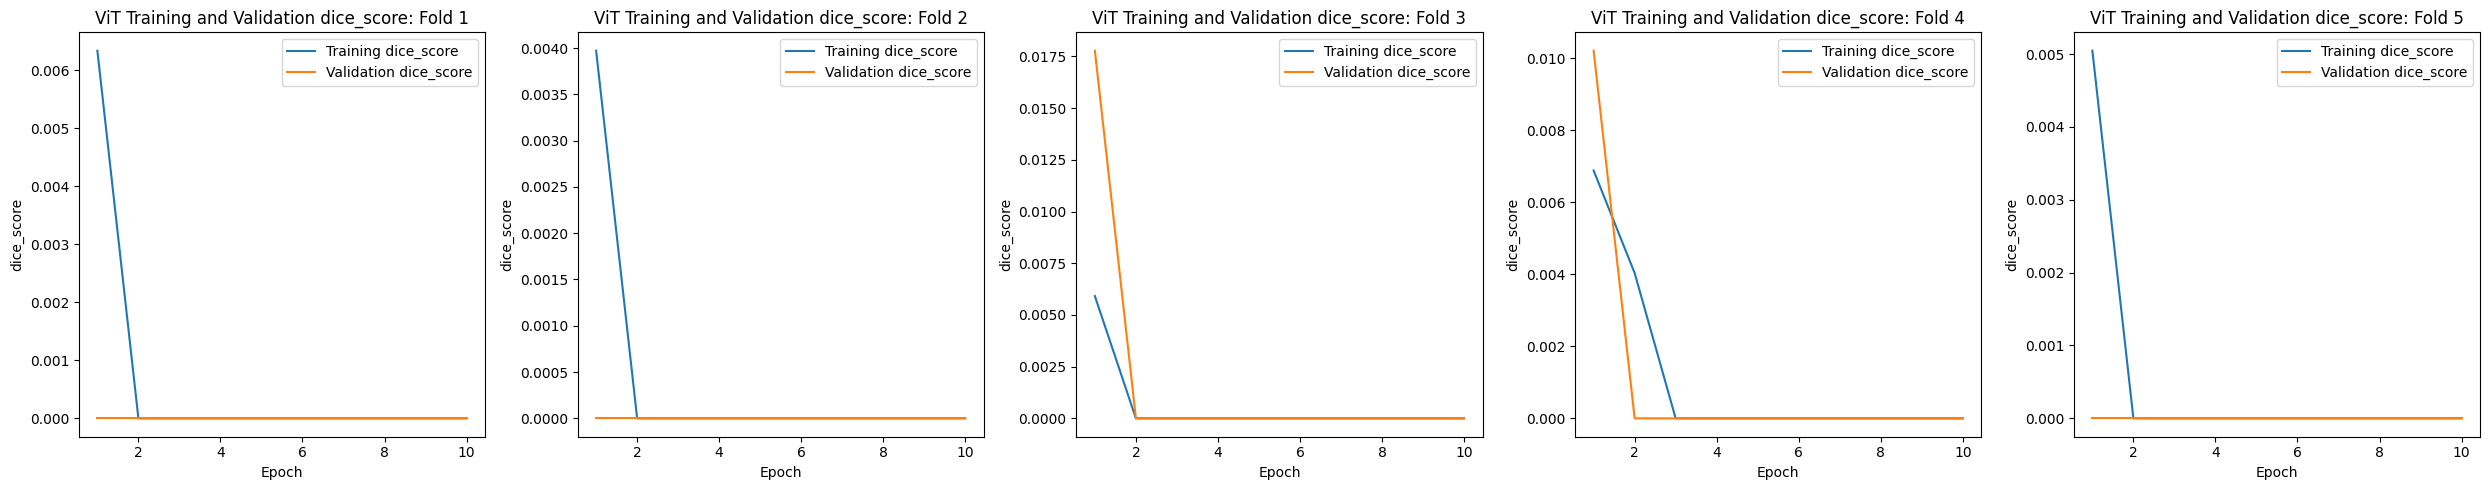

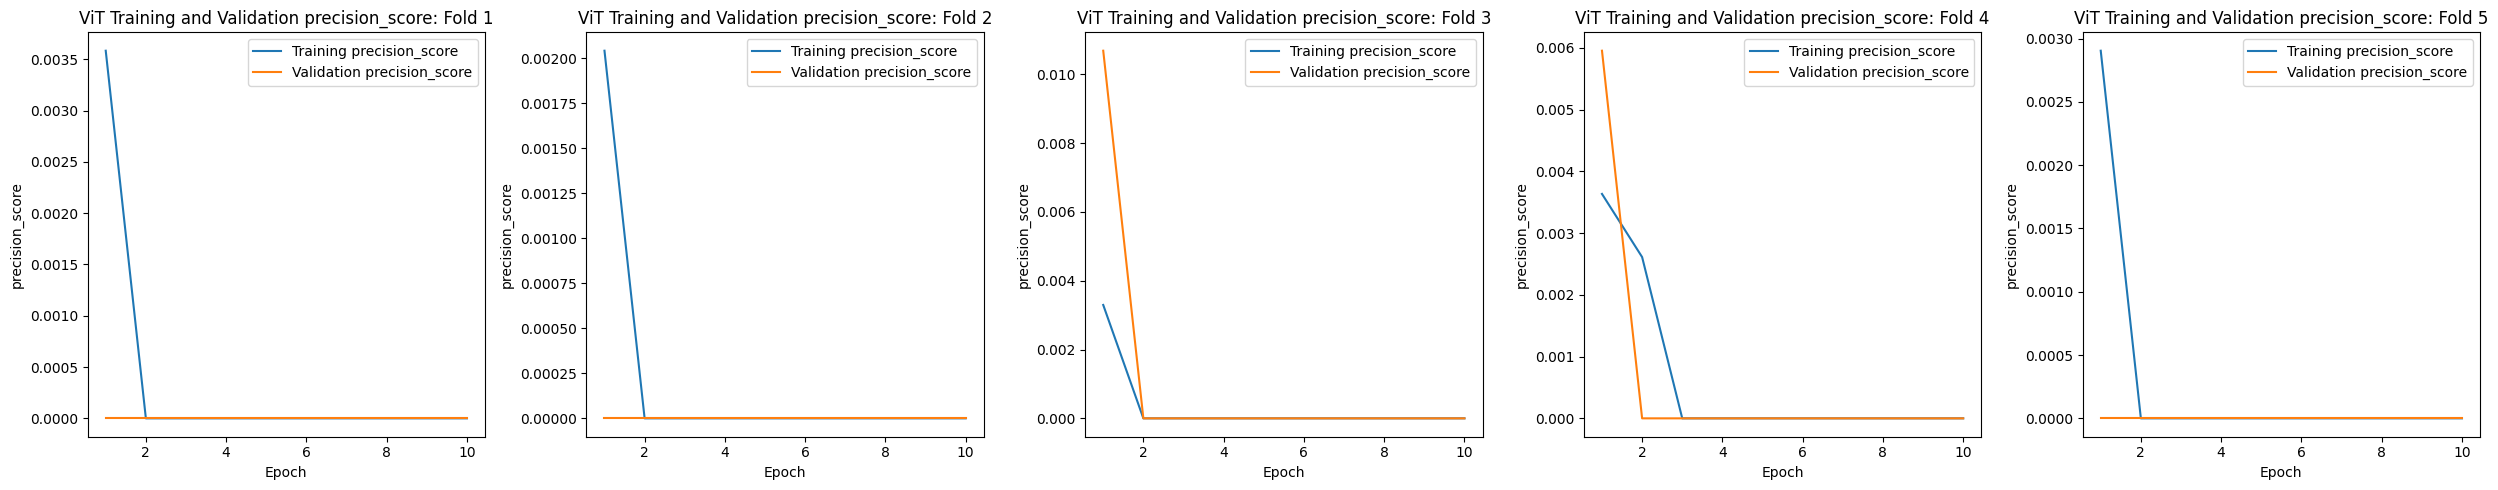

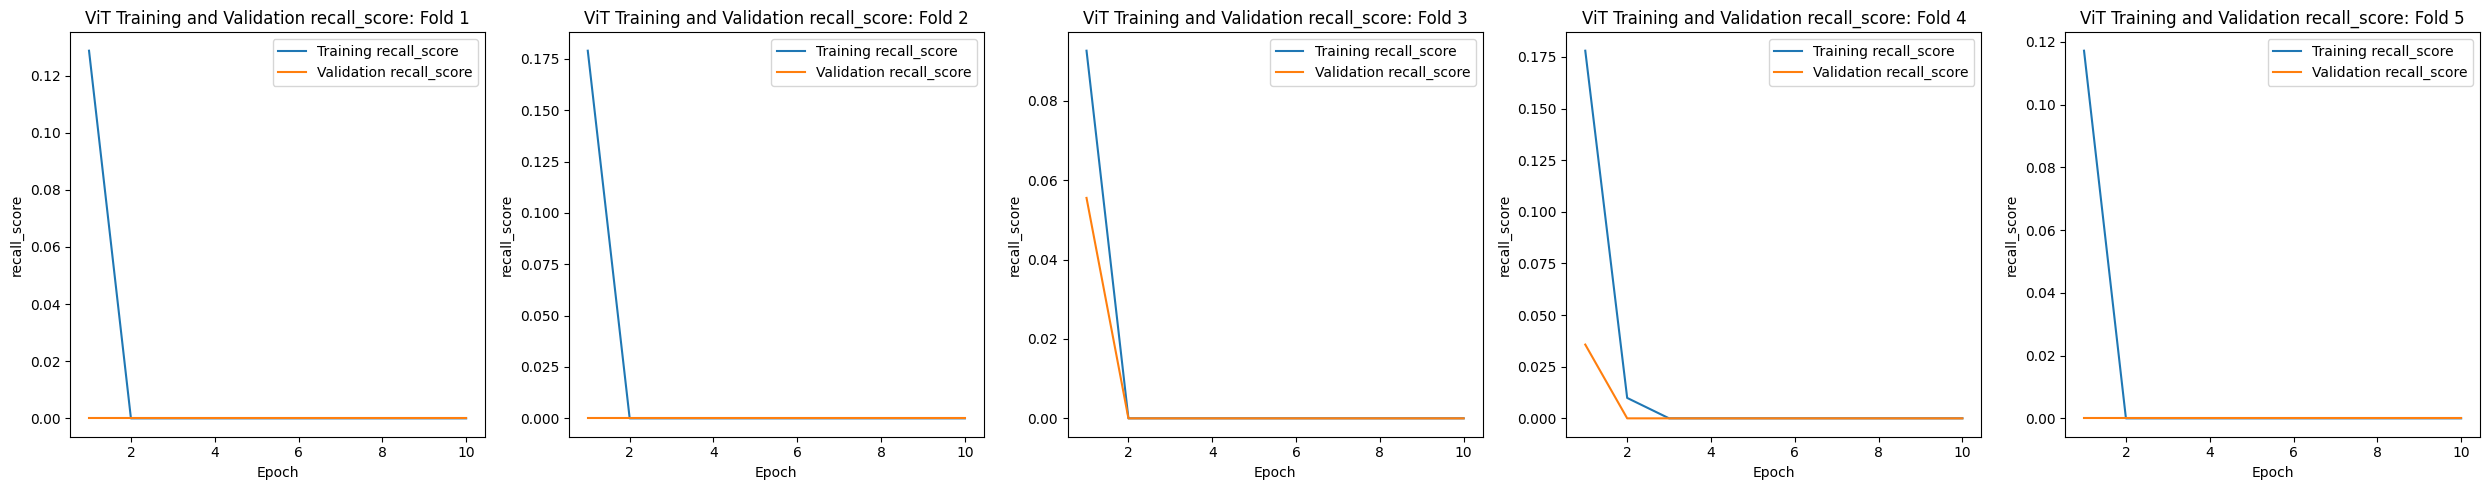

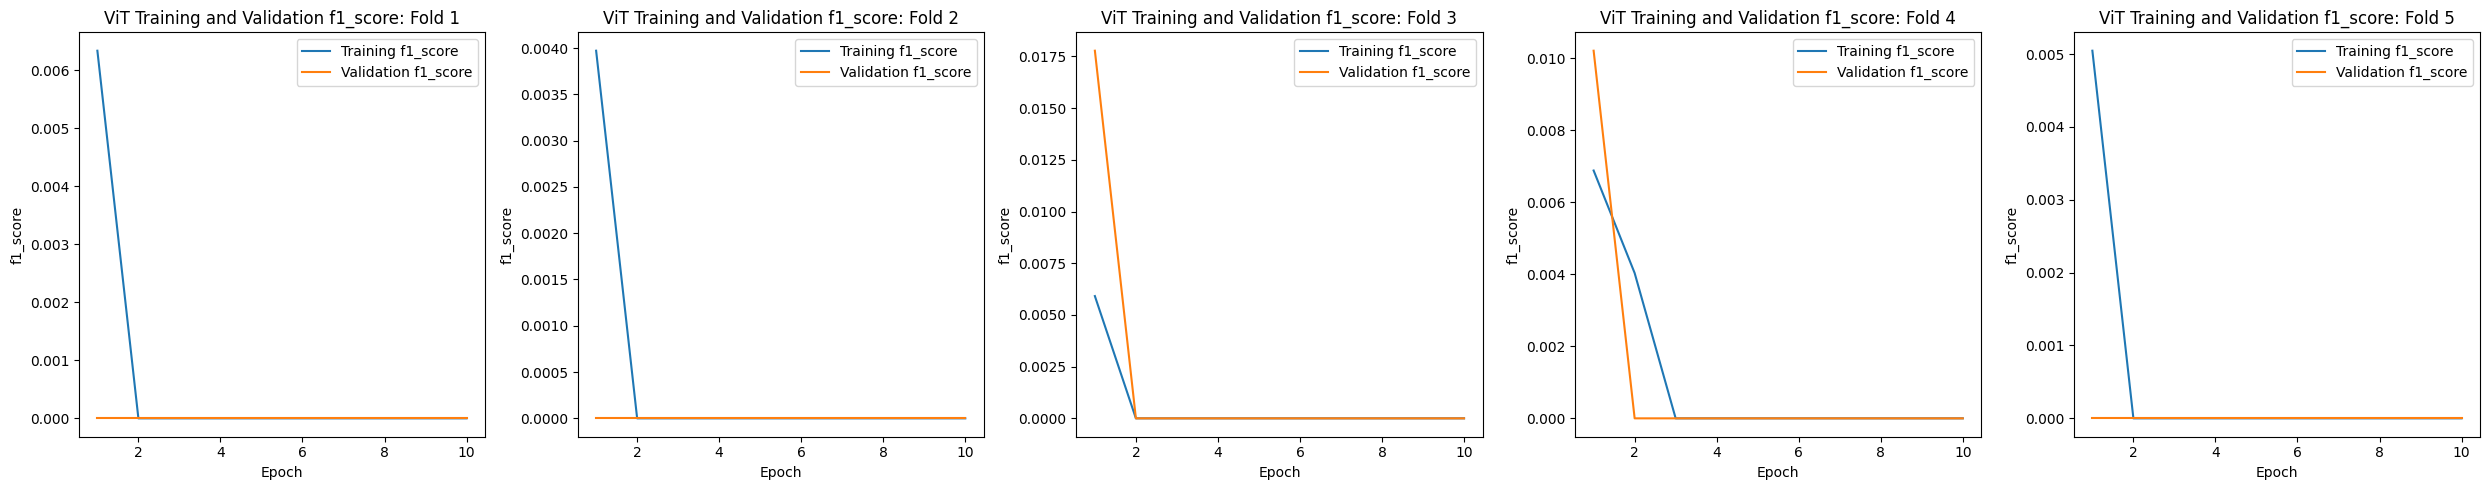

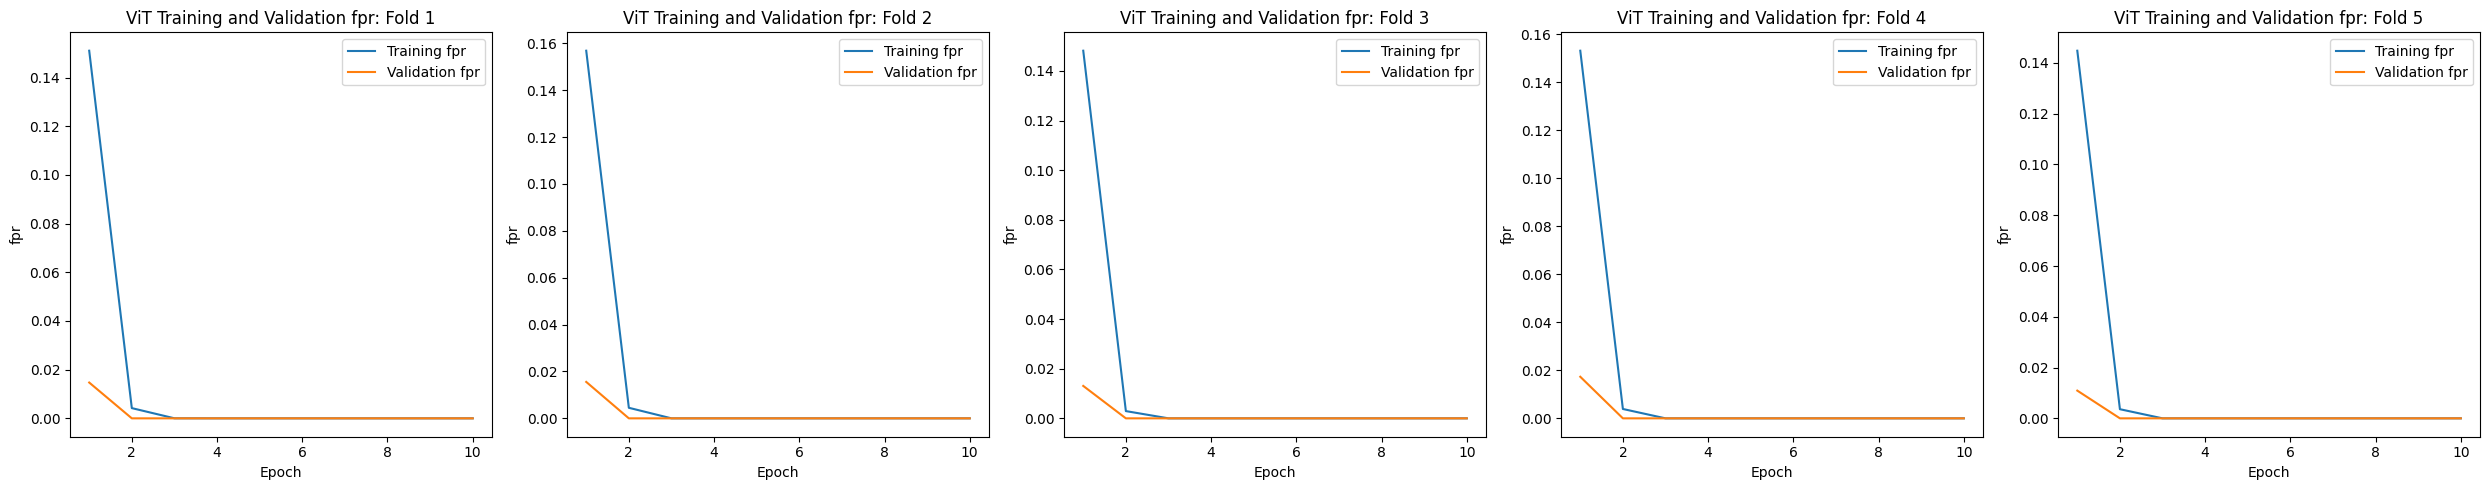

In [24]:
vit_metrics = ['dice_score', 'precision_score', 'recall_score', 'f1_score', 'fpr']

for metric in vit_metrics:
    plot_metric_history(vit_fold_metrics, metric, 'ViT ')

### Loss History Visualization


In [25]:
def plot_loss_history(fold_metrics, title=None):
    fig, axes = plt.subplots(1, 5, figsize=(25, 5))

    for fold in range(5):
        train = []
        test = []
        ax=axes[fold]
        
        for epoch in range(len(fold_metrics[fold]['training_history'])):
            th = np.array(fold_metrics[fold]['training_history'][epoch]).mean()
            train.append(th)
            vh = np.array(fold_metrics[fold]['validation_history'][epoch]).mean()
            test.append(vh)
        
        sns.lineplot(x=range(1, len(train)+1), y=train, label='Training history', ax=ax)
        sns.lineplot(x=range(1, len(test)+1), y=test, label='Validation history', ax=ax)
        
        ax.set_title(f'{title}Training and Validation History: Fold {fold+1}')
        ax.set_xlabel('Epoch')
        ax.set_ylabel('Loss')
        ax.legend()
    
    plt.tight_layout()  
    plt.show()

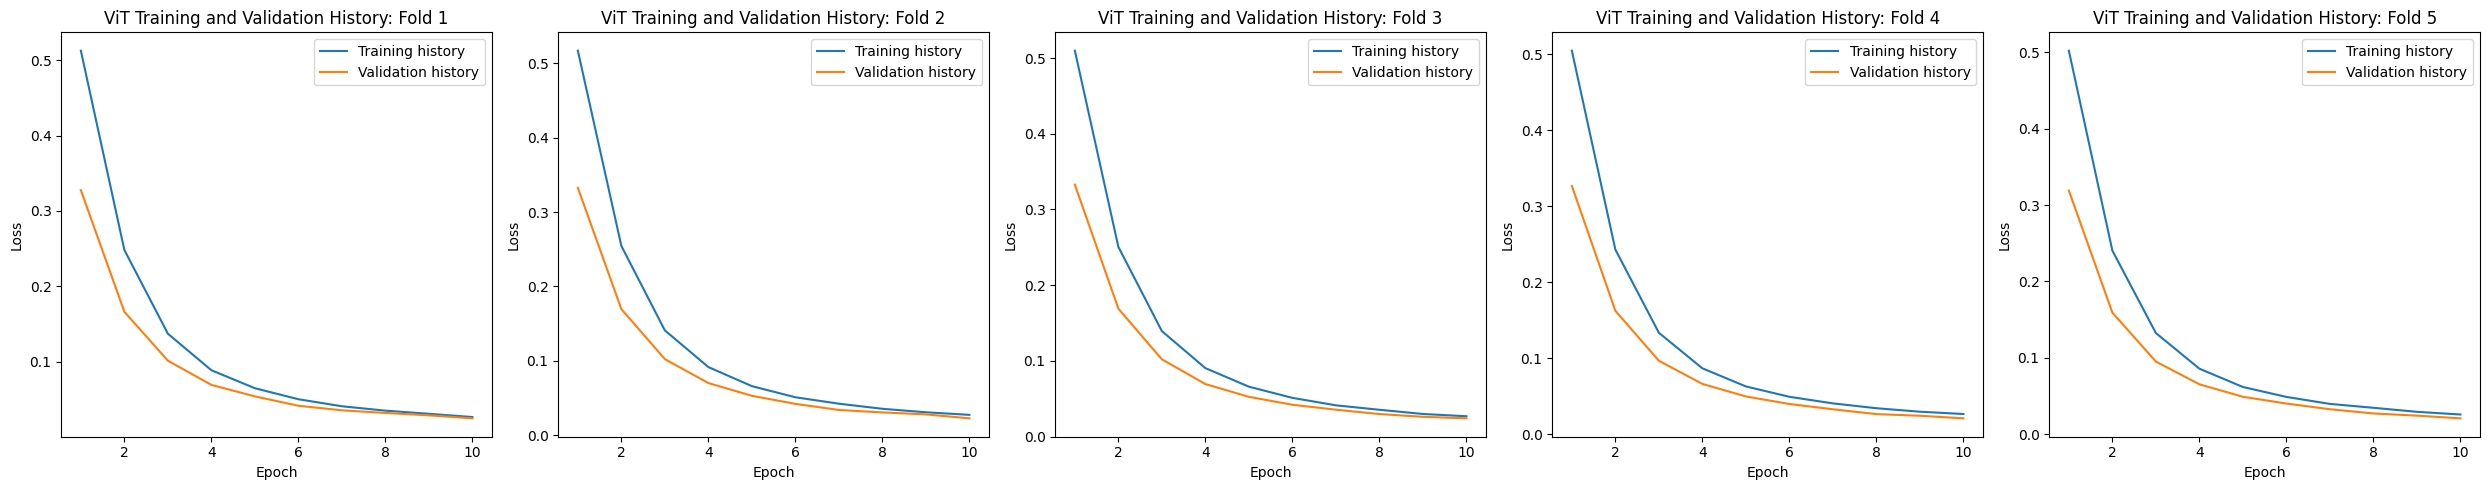

In [26]:
plot_loss_history(vit_fold_metrics, 'ViT ')

### Evaluate Test Set


#### ViT


In [27]:
df_vit_metrics = pd.DataFrame(columns=['fold', 'dice', 'precision', 'recall', 'f1', 'fpr'])
df_vit_metrics

,fold,dice,precision,recall,f1,fpr


In [28]:
df_vit_metrics['fold'] = [1, 2, 3, 4, 5]
df_vit_metrics['dice'] = vit_test_dice
df_vit_metrics['precision'] = vit_test_precision
df_vit_metrics['recall'] = vit_test_recall
df_vit_metrics['f1'] = vit_test_f1
df_vit_metrics['fpr'] = vit_test_fpr

In [29]:
vit_tk.dice = df_vit_metrics.dice
vit_tk.precision = df_vit_metrics.precision
vit_tk.recall = df_vit_metrics.recall
vit_tk.f1 = df_vit_metrics.f1
vit_tk.fpr = df_vit_metrics.fpr

In [30]:
df_vit_metrics

,fold,dice,precision,recall,f1,fpr
0,1,0.0,0.0,0.0,0.0,0.0
1,2,0.0,0.0,0.0,0.0,0.0
2,3,0.0,0.0,0.0,0.0,0.0
3,4,0.0,0.0,0.0,0.0,0.0
4,5,0.0,0.0,0.0,0.0,0.0


In [31]:
# vit_iou_score = np.array(vit_test_iou).mean()
vit_dice_score = np.array(vit_test_dice).mean()
vit_precision_score = np.array(vit_test_precision).mean()
vit_recall_score = np.array(vit_test_recall).mean()
vit_f1_score = np.array(vit_test_f1).mean()
vit_fpr_score = np.array(vit_test_fpr).mean()

print('ViT Test Set Performance Metrics')
print(f'Average Dice Score: {vit_dice_score} ')
print(f'Average Precision: {vit_precision_score} ')
print(f'Average Recall: {vit_recall_score} ')
print(f'Average F1 Score: {vit_f1_score} ')
print(f'Average FPR: {vit_fpr_score} ')

ViT Test Set Performance Metrics
Average Dice Score: 0.0 
Average Precision: 0.0 
Average Recall: 0.0 
Average F1 Score: 0.0 
Average FPR: 0.0 


In [32]:
df_vit_metrics.to_csv(f'{fold_dir}/vit_metrics.csv')

### Sample


#### ViT


In [33]:
vit_sample = next(enumerate(vit_test_dataloader))
vit_slices, vit_masks, vit_target, vit_case = vit_sample[1][0]

In [34]:
# vit_slices = vit_slices.squeeze(1).float().to(device)
vit_slices = vit_slices.squeeze(1).repeat(1, 3, 1, 1).float().to(device)
vit_masks = vit_masks.float().to(device)

In [35]:
vit_x, vit_t = stone(vit_slices, vit_masks, vit_target)

<Axes: title={'center': 'Mask Slice Crop'}>

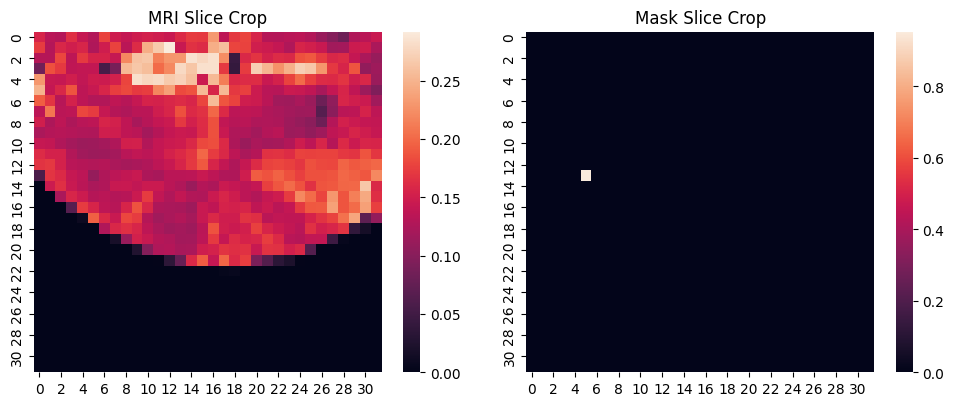

In [36]:
f, a = plt.subplots(1, 2, figsize=(10, 4))

f.tight_layout()
ax1 = a.flat[0]
ax2 = a.flat[1]
ax1.set_title('MRI Slice Crop')
ax2.set_title('Mask Slice Crop')
sns.heatmap(vit_x[vit_target].squeeze(), ax=ax1)
sns.heatmap(vit_t[vit_target].squeeze(), ax=ax2)

In [37]:
vit_y = vit_fitter.model(vit_x.flatten(2).to(device), vit_target)
vit_y = vit_y.view(32, 32)

<Axes: title={'center': 'Mask Truth'}>

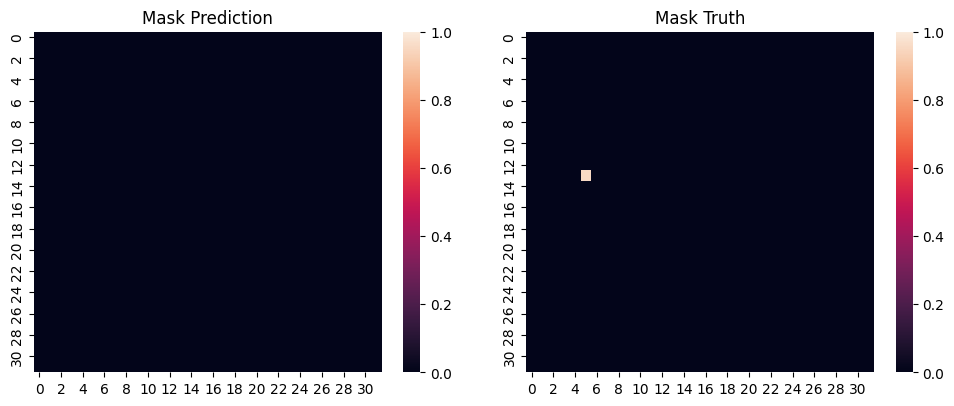

In [38]:
f, a = plt.subplots(1, 2, figsize=(10, 4))

f.tight_layout()
ax1 = a.flat[0]
ax2 = a.flat[1]
ax1.set_title('Mask Prediction')
ax2.set_title('Mask Truth')
sns.heatmap((vit_y > -0.3).detach().cpu(), ax=ax1, vmax=1)
sns.heatmap(vit_t[vit_target].squeeze(), ax=ax2, vmax=1)

# Log Progress


In [39]:
vit_tk.notes = '''
Global Context
'''

In [40]:
vit_tk()

,model,loaded_weights,stage1_weights,uses_resnet,only_cmb_slices,cohort1,cohort2,cohort3,optimizer,epochs,...,recall,f1,fpr,saved_weights,saved_thist,saved_vhist,model_hyperparams,logfile,device,notes
date,,,,,,,,,,,,,,,,,,,,,
2024-11-20 23:46:02.982540,ViT,None,fold\Nov_20_2024_225758\fold_1\rpn_fold1.pt,None,True,True,False,True,<class 'torch.optim.adam.Adam'>,10,...,0 0.0 1 0.0 2 0.0 3 0.0 4 0.0 N...,0 0.0 1 0.0 2 0.0 3 0.0 4 0.0 N...,0 0.0 1 0.0 2 0.0 3 0.0 4 0.0 N...,None,None,None,"{'d_model': 512, 'patch_size': 32, 'dim_ff': 1...",rpn_vit_Nov_20_2024_234602.log,cuda,\nGlobal Context\n


In [ ]:
if os.path.exists('history/runs.csv'):
    print('Merging to old df')

    prev_df = pd.read_csv('history/runs.csv', index_col='date')
    merged = pd.concat([prev_df, vit_tk()])
    merged.to_csv('history/runs.csv')
else:
    print('Making new csv file')
    vit_tk().to_csv('history/runs.csv')

Merging to old df


C:\Users\Lex Zedrick Lorenzo\AppData\Local\Temp\ipykernel_55240\3825574670.py:5: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  merged = pd.concat([prev_df, vit_tk()])
